# Gradient Boosting

Author: Luke Moraglia

This notebook gives an overview of the gradient boosting algorithm for classification and regression.
It implements a `GradientBoostingClassifier` from `scikit-learn`.

(Re)Sources:
- [Wikipedia](https://en.wikipedia.org/wiki/Gradient_boosting)
- [Statquest](https://youtube.com/playlist?list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6)
- [sklearn](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting)

# Method Overview

Gradient boosting is a tree-based ensemble method, meaning that it aggregates the predictions of many simple trees&mdash;called *weak learners*&mdash;to get its final prediction.
Simple decision trees tend to have high variance, which could lead to overfitting, but gradient boosting reduces the variance through aggregation.
Unlike random forest, which builds weak learners independently of one another using boostrapped samples, gradient boosting builds weak learners sequentially.
Each new weak learner improves on the predictions of the previous weak learners by trying to predict the errors (sometimes called *residuals* or *psuedo-residuals*) of the previous weak learners.
The errors are determined by a loss function that the algorithm attempts to minimize; two common choices for loss functions are mean square error for regression and negative log likelihood for classification.

## Example: the math of gradient boosting regression
Here we seek a model $F$ which makes predictions $\hat{y} = F(x)$ that minimize the mean square error $\frac{1}{n} \sum_{i}(\hat{y}_{i} - y_{i})^2$. We start off with an initial model $F_{1}$, which is a single leaf node that contains the mean of $y$. Every sample receives the mean as its prediction, but how good is this prediction? We calculate the residuals as $y_{i} - F_{1}(x_{i})$. To improve on our prediction, we create a new weak learner, $h_{1}$, that predicts the residuals. Once this tree is fitted, we add its prediction to $F_{1}$ to update our model as $F_{2} = F_{1} + h_{1}$. This process repeats as $F_{m+1} = F_{m} + h_m$ until the set maximum value of $m$ is reached.

## Learning rate
Rather than always adding the full prediction of $h_m$, gradient boosting will typically scale the predictions made by $h_m$ by some constant, $\lambda$, called the learning rate. This means that every weak learner takes a small step in the correct direction of minimizing the loss function. This is equivalent to gradient descent, which is where gradient boosting gets its name.


# `GradientBoostingClassifier` from `scikit-learn`
# Library Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 9]
plt.style.use("fivethirtyeight")

# Create example dataset

In [2]:
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_redundant=0, 
    n_informative=6,
    n_classes=2,
    n_clusters_per_class=1,
    class_sep=0.01,
    weights=[.8, .2],
    flip_y=0.1,
    random_state=42
)

In [3]:
X = pd.DataFrame(X, columns=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'])
X.head()

,a,b,c,d,e,f,g,h,i,j
0,0.182171,0.891878,0.385882,0.098521,0.362450,-0.188841,1.167629,-0.509894,-0.583674,-1.195221
1,-0.701290,-0.875815,0.368107,1.809190,-0.214538,-1.119109,-0.041043,-3.601085,-0.972224,1.243674
2,-0.034942,-0.907327,-0.816835,-0.024559,-0.389404,-1.280401,-1.252989,1.355805,1.007838,0.226701
3,0.450812,0.209686,-2.684636,0.532479,-0.828294,-1.399258,0.712249,0.120199,1.968364,2.375612
4,0.165240,0.012522,-2.009091,-2.292507,-0.172041,0.204429,-1.767424,1.438169,-0.620754,0.271226


In [4]:
y = pd.Series(y, name = 'Target')
y.head()

0    1
1    0
2    1
3    1
4    0
Name: Target, dtype: int32

# Train Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [6]:
X_train.head()

,a,b,c,d,e,f,g,h,i,j
29,-1.080407,-1.177417,-0.252406,0.518243,-1.293122,0.063341,-0.475537,0.083873,-1.448200,0.522187
535,-2.350456,1.672868,-1.168580,-1.455152,-0.948953,1.165881,-2.912987,-0.906903,-0.786544,0.240706
695,1.143362,0.184859,0.299939,1.674055,1.617045,-1.930882,0.613958,-0.770425,-1.146700,1.415465
557,0.676357,-0.037687,-0.342550,-0.840566,0.925282,0.579295,-1.602249,0.168651,1.177709,0.509090
836,-2.343039,-0.614038,1.452442,-0.689007,-0.192981,-0.619968,-0.353779,-1.782115,0.217538,-0.628428


In [7]:
y_train.head()

29     0
535    0
695    0
557    0
836    1
Name: Target, dtype: int32

# Visualize Training Data with PCA
I want to visualize the training dataset that we have created, so we will use PCA to project the data from 10 dimensions down to 2 dimensions. The points in the scatter plot will be colored by their group membership (0 or 1).

In [8]:
pca_out = PCA().fit(X_train)

In [9]:
# Percentage of variance explained by the first two components
round(sum(pca_out.explained_variance_ratio_[:2]), 2)

0.46

In [10]:
# Factor scores
fscores = pca_out.transform(X_train)

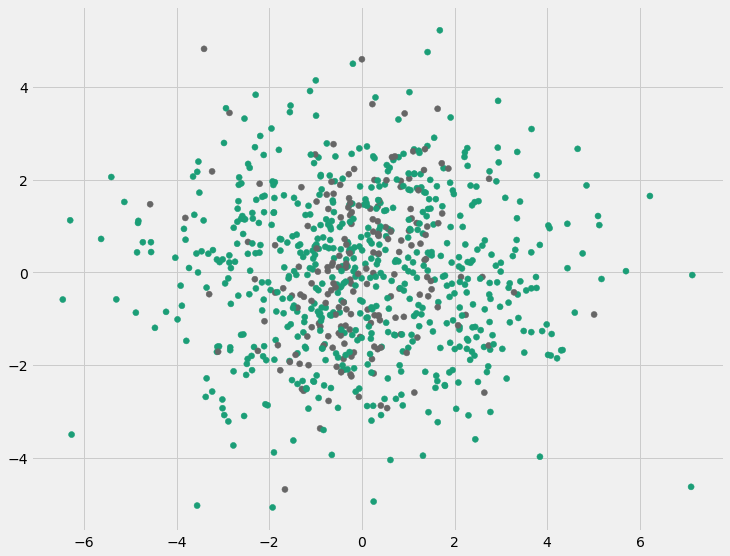

In [11]:
# Plot fscores for first two components
sc = plt.scatter(fscores[:, 0], fscores[:, 1],
                 c=y_train, cmap=plt.cm.get_cmap('Dark2', 2))
ax = sc.axes
ax.set_aspect('equal')

In this two-dimensional subspace, the two classes are highly overlapping.

# Train Model

## Hyperparameters to consider
- n_estimators: the number of weak learners to train
- criterion: the criterion used to build the weak learners, such as Gini impurity or entropy.
- max_depth: maximum depth of each weak learner
- min_samples_split: the minimum number of samples required to split a node
- min_samples_leaf: the minimum number of samples required in a leaf node
- max_features: the number of predictors to consider at each split

## Grid Search CV

In [12]:
# This takes a while to run, so if you want to skip it, see below for the best model
# %%time
# param_grid = {
#     'n_estimators': [200, 500],
#     'max_depth': [1, 2, 3, 5],
#     'min_samples_split': [5, 25, 100],
#     'min_samples_leaf': [1, 5, 25, 150],
#     'max_features': [None, 'sqrt'] # None means use all predictors
# }

# gbm = GradientBoostingClassifier(random_state=0, loss='log_loss')
# gbm_grid = GridSearchCV(gbm,
#                         param_grid,
#                         cv=5,
#                         scoring='roc_auc',
#                         n_jobs=-1)
# gbm_grid.fit(X_train, y_train)
# model = gbm_grid.best_estimator_
# gbm_grid.best_params_    

In [14]:
# Results from code block above
model = GradientBoostingClassifier(max_depth=3,
                                   max_features=None,
                                   min_samples_leaf=150,
                                   min_samples_split=5,
                                   n_estimators=500,
                                   random_state=0,
                                   loss='log_loss', # The default loss function
                                   verbose = 1)
model.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.0784            1.99s
         2           1.0694            1.49s
         3           1.0577            1.32s
         4           1.0386            1.11s
         5           1.0263            1.09s
         6           1.0119            1.07s
         7           0.9963            1.05s
         8           0.9885            1.04s
         9           0.9778            0.98s
        10           0.9640            0.98s
        20           0.8574            0.93s
        30           0.7852            0.95s
        40           0.7324            0.99s
        50           0.6904            0.99s
        60           0.6594            0.92s
        70           0.6359            0.86s
        80           0.6156            0.81s
        90           0.5949            0.78s
       100           0.5752            0.74s
       200           0.4492            0.50s
       300           0.3626            0.33s
       40

GradientBoostingClassifier(min_samples_leaf=150, min_samples_split=5,
                           n_estimators=500, random_state=0, verbose=1)

# Model Performance

## ROC AUC Score

In [15]:
y_pred_train = model.predict_proba(X_train)[:,1]
y_pred_test = model.predict_proba(X_test)[:,1]

auc_train = metrics.roc_auc_score(y_train, y_pred_train)
auc_test = metrics.roc_auc_score(y_test, y_pred_test)

print(f"Train AUC Score = {round(auc_train, 3)}")
print(f"Test AUC Score = {round(auc_test, 3)}")

Train AUC Score = 0.997
Test AUC Score = 0.847


## ROC Curve

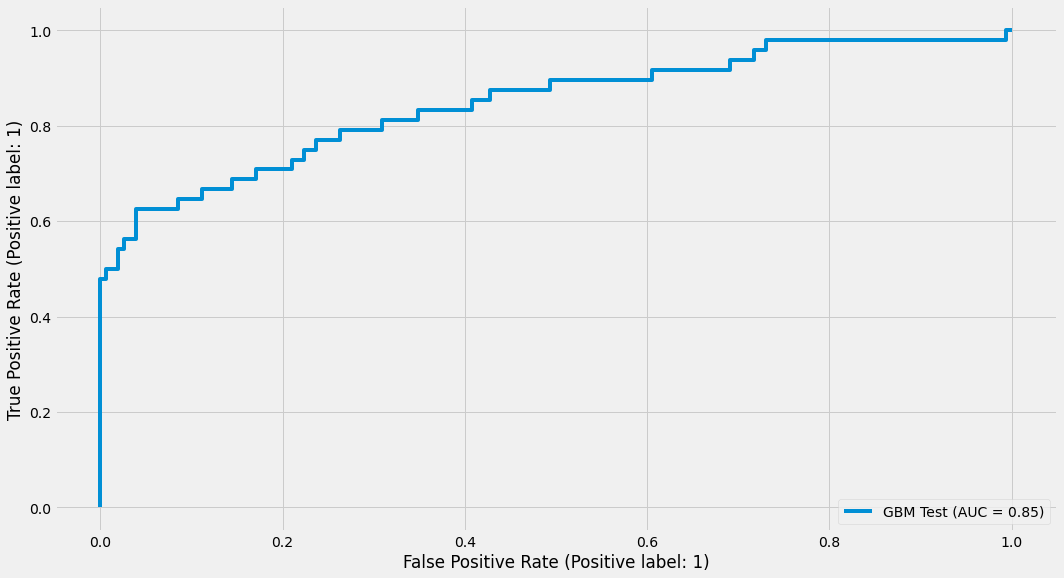

In [16]:
RocCurveDisplay.from_estimator(model, X_test, y_test, name = "GBM Test")

## Precision Recall Curve

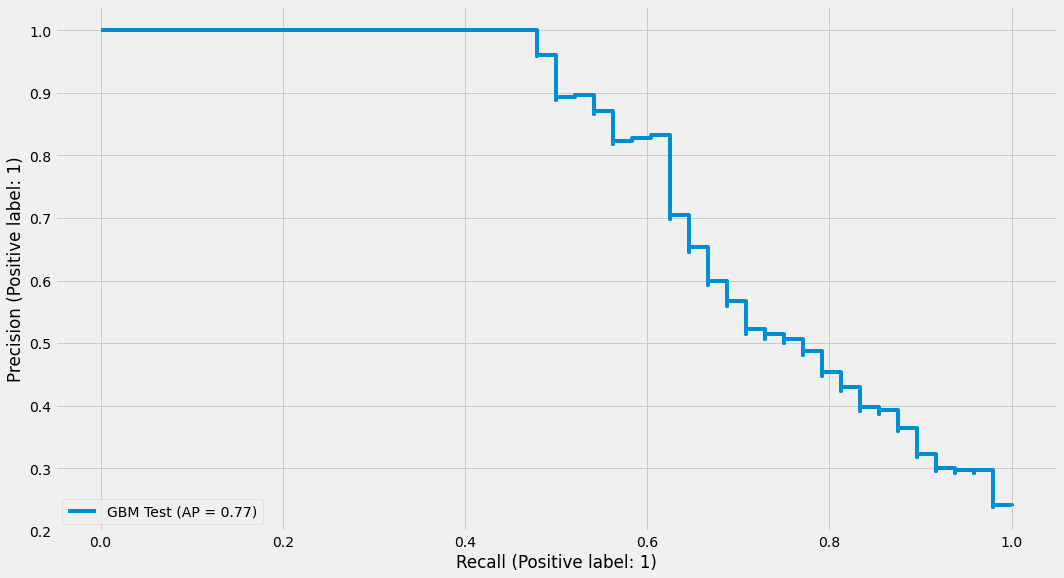

In [17]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred_test, name = "GBM Test")

# Variable Importance

## Permutation Feature Importance

In [18]:
%%time
perm_feat_imp = permutation_importance(model,
                                       X_train,
                                       y_train,
                                       scoring = 'roc_auc',
                                       n_repeats = 30,
                                       random_state = 42)
                                       

CPU times: total: 2.86 s
Wall time: 2.86 s


In [19]:
forest_imp = pd.Series(perm_feat_imp.importances_mean,
                       index = X_train.columns).sort_values(ascending = False)
forest_imp.head()

d    0.102610
f    0.086225
c    0.081965
i    0.057676
g    0.023875
dtype: float64

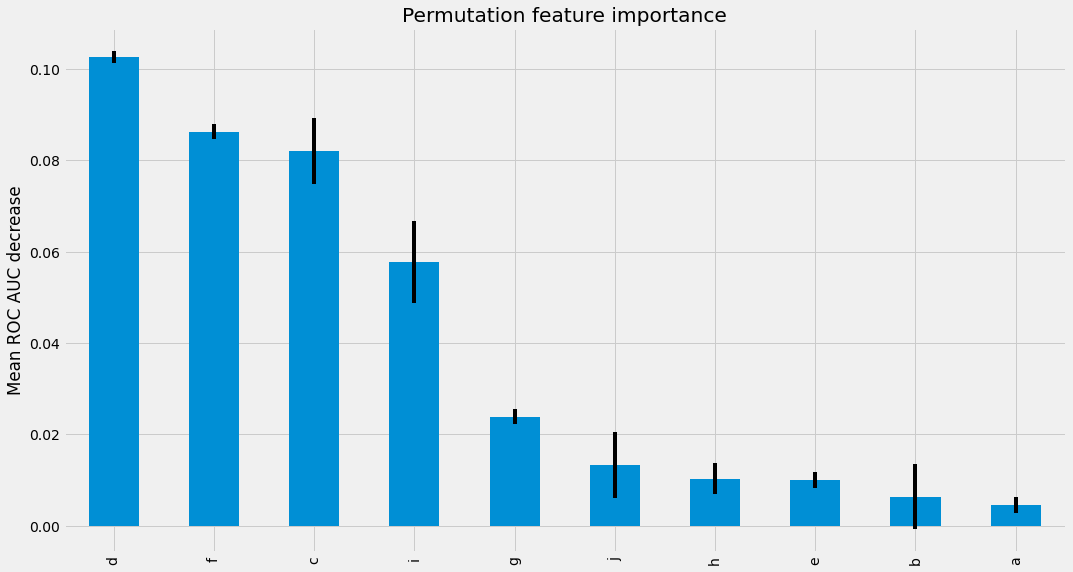

In [20]:
fig, ax = plt.subplots()
forest_imp.plot.bar(yerr=perm_feat_imp.importances_std, ax = ax)
ax.set_title("Permutation feature importance")
ax.set_ylabel("Mean ROC AUC decrease")
plt.show()